In [1]:
# Dependencies and setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import gmaps
import os
import json
from pprint import pprint

# Import API key
from config import g_key

In [2]:
# import cleaned master crime csv file
master_file = "Data Output/Toronto_Crimes_Occurred_2014_2019.csv"

# create a dataframe from the master data
master_df = pd.read_csv(master_file, index_col=0)


### Q2. Which neighborhoods experience the highest and lowest crime rates in Toronto? 
    a. How close were police stations to where the crime occurred?

In [3]:
# ************************************************************************************************
# use master crime dataset to generate heat map of total crimes across Toronto by neighbourhood
# ************************************************************************************************

# configure gmaps figure
gmaps.configure(api_key=g_key)

# Toronto's coordinates for centering the map
toronto_coords = (43.70, -79.33)

# create base map
fig = gmaps.figure(center=toronto_coords, zoom_level=11)
locations = master_df[["Lat", "Long"]]

heatmap_layer = gmaps.heatmap_layer(locations)
fig.add_layer(heatmap_layer)

# adjust layer settings for increased visibility
heatmap_layer.max_intensity = 100
heatmap_layer.point_radius = 4
fig

Figure(layout=FigureLayout(height='420px'))

In [4]:
# ************************************************************************************************
# find the neighborhoods that experience the highest and lowest crime rates in Toronto
# ************************************************************************************************

# sort the master dataframe by neighbourhood ID and create a dictionary with relevant neighbourhood details
master_df_sorted = master_df.sort_values("Hood_ID")
neighbourhood_crimes_dict = {"Neighbourhood ID": master_df_sorted["Hood_ID"].unique(),
                             "Neighbourhood": master_df_sorted.groupby("Hood_ID")["Neighbourhood"].unique(),
                             "Hood Lat": master_df_sorted.groupby("Hood_ID")["Lat"].mean(),
                             "Hood Lng": master_df_sorted.groupby("Hood_ID")["Long"].mean(),
                             "No. of Crimes": master_df_sorted.groupby("Hood_ID")["Hood_ID"].count()
}

# create new dataframe from the dictionary and sort in descending order for mapping 
neighbourhood_crimes_df = pd.DataFrame(neighbourhood_crimes_dict).set_index("Neighbourhood ID")

neighbourhood_crimes_df.sort_values("No. of Crimes", ascending=False, inplace=True)
neighbourhood_crimes_df.reset_index(drop=True, inplace=True)

# create dataframes with top 10 crime (most crime) and bottom 10 (least crime) neighbourhoods 
most_crimes_neighbourhoods = neighbourhood_crimes_df.head(10)
least_crimes_neighbourhoods = neighbourhood_crimes_df.tail(10).sort_values("No. of Crimes").reset_index(drop=True)


In [5]:
# display 10 neighbourhoods with most crimes
most_crimes_neighbourhoods

,Neighbourhood,Hood Lat,Hood Lng,No. of Crimes
0,[Waterfront Communities-The Island (77)],43.644959,-79.387431,9984
1,[Bay Street Corridor (76)],43.657212,-79.383738,8765
2,[Church-Yonge Corridor (75)],43.659622,-79.379598,7641
3,[West Humber-Clairville (1)],43.721569,-79.597207,5759
4,[Moss Park (73)],43.656880,-79.369331,5502
5,[Kensington-Chinatown (78)],43.653612,-79.397825,4551
6,[York University Heights (27)],43.763923,-79.489869,4131
7,[Downsview-Roding-CFB (26)],43.727890,-79.498073,4039
8,[Woburn (137)],43.766636,-79.228039,3854
9,[Annex (95)],43.670567,-79.402060,3653


In [6]:
# display 10 neighbourhoods with least crimes
least_crimes_neighbourhoods

,Neighbourhood,Hood Lat,Hood Lng,No. of Crimes
0,[Lambton Baby Point (114)],43.659076,-79.495543,397
1,[Woodbine-Lumsden (60)],43.694210,-79.312666,398
2,[Maple Leaf (29)],43.714195,-79.480897,408
3,[Guildwood (140)],43.748982,-79.198807,424
4,[Markland Wood (12)],43.634161,-79.573765,467
5,[Old East York (58)],43.694486,-79.337386,493
6,[Yonge-St.Clair (97)],43.688566,-79.396944,505
7,[Humber Heights-Westmount (8)],43.692357,-79.522358,525
8,[Centennial Scarborough (133)],43.782788,-79.149991,530
9,[Etobicoke West Mall (13)],43.644921,-79.567969,539


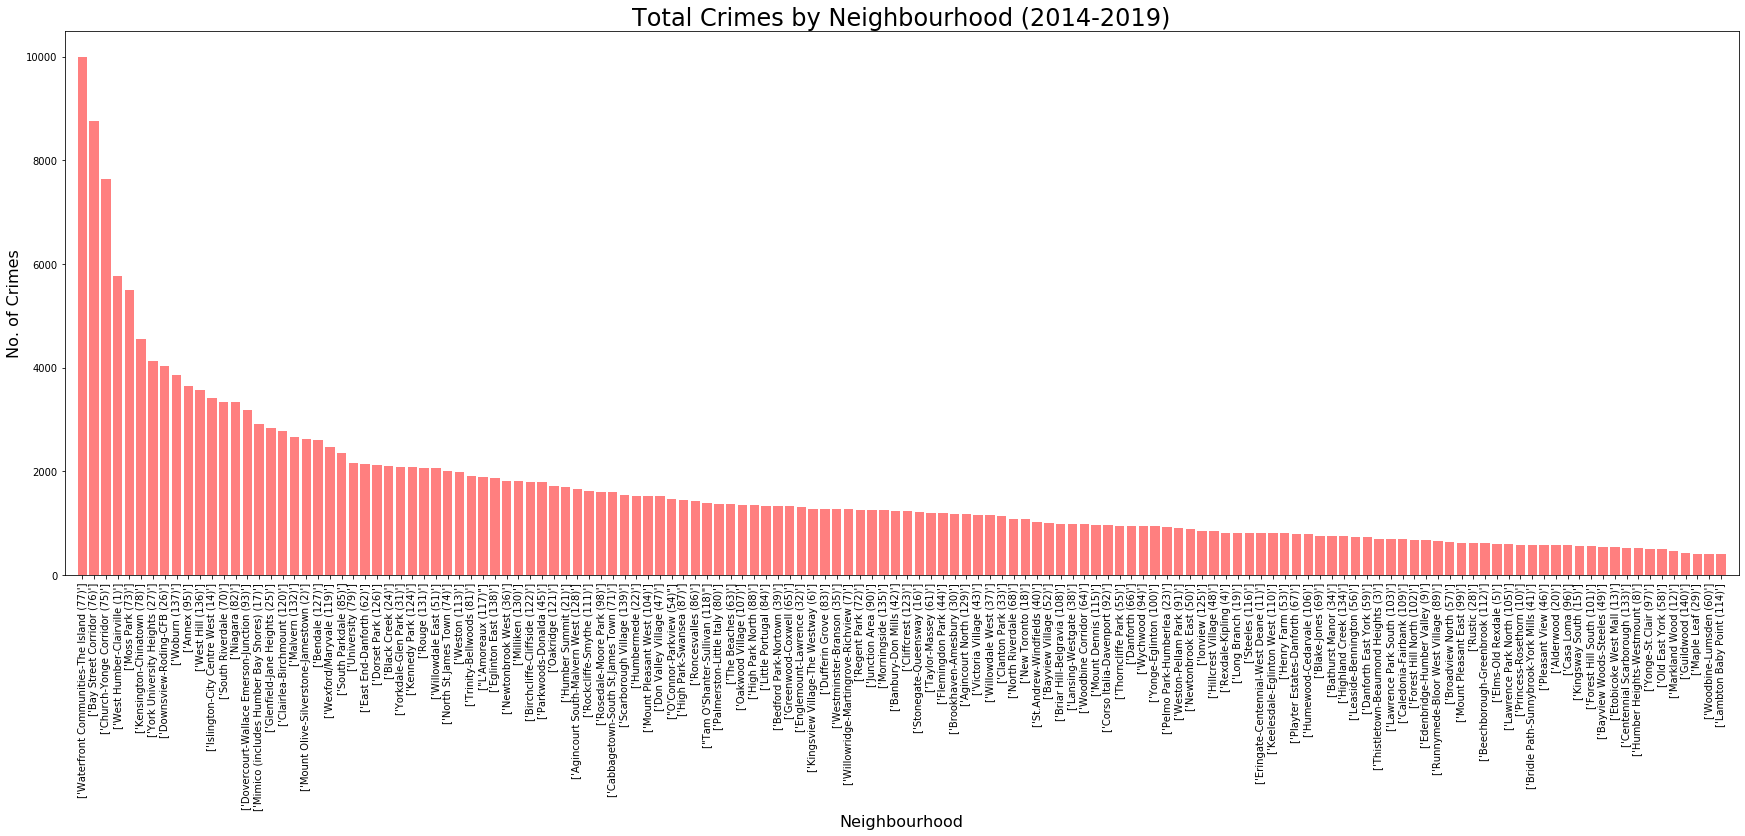

<Figure size 432x288 with 0 Axes>

In [7]:
# *****************************************************
# plot a bar graph with total crimes by neighbourhood
# *****************************************************

# set x axis and tick locations
x_axis = np.arange(len(neighbourhood_crimes_df))
tick_locations = [value for value in x_axis]

# create a list indicating where to write x labels and set figure size to adjust for space
plt.figure(figsize=(30,10))
plt.bar(x_axis, neighbourhood_crimes_df["No. of Crimes"], color='r', alpha=0.5, align="center")
plt.xticks(tick_locations, neighbourhood_crimes_df["Neighbourhood"], rotation="vertical")

#neighbourhood_crimes_df.plot(kind="bar")

# set limits, title, labels
plt.title("Total Crimes by Neighbourhood (2014-2019)", fontsize=24)
plt.ylabel("No. of Crimes", fontsize=16)
plt.xlabel("Neighbourhood", fontsize=16)

plt.xlim(-1.5,max(x_axis)+1.5)
plt.show()
plt.tight_layout()





In [8]:
# **************************************************************************************************
# find the geocoordinates of Toronto police stations in the top 10 neighbourhoods with most crimes
# to add as markers on heatmap
# **************************************************************************************************

# create a column with initially null values for police station and its location
most_crimes_neighbourhoods["Police Station"] = np.nan
most_crimes_neighbourhoods["Police Station Lat"] = np.nan
most_crimes_neighbourhoods["Police Station Lng"] = np.nan
     
# set up parameters for querying Google Places API 
target_search = "police"
target_radius = 5000
target_type = "police"

# set up a parameters dictionary 
params = {
    "keyword": target_search,
    "radius": target_radius,
    "type": target_type,
    "key": g_key
}

# --- define base url ---
base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
most_crimes_neighbourhoods



/Users/nehanayeem/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/nehanayeem/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/nehanayeem/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

,Neighbourhood,Hood Lat,Hood Lng,No. of Crimes,Police Station,Police Station Lat,Police Station Lng
0,[Waterfront Communities-The Island (77)],43.644959,-79.387431,9984,NaN,NaN,NaN
1,[Bay Street Corridor (76)],43.657212,-79.383738,8765,NaN,NaN,NaN
2,[Church-Yonge Corridor (75)],43.659622,-79.379598,7641,NaN,NaN,NaN
3,[West Humber-Clairville (1)],43.721569,-79.597207,5759,NaN,NaN,NaN
4,[Moss Park (73)],43.656880,-79.369331,5502,NaN,NaN,NaN
5,[Kensington-Chinatown (78)],43.653612,-79.397825,4551,NaN,NaN,NaN
6,[York University Heights (27)],43.763923,-79.489869,4131,NaN,NaN,NaN
7,[Downsview-Roding-CFB (26)],43.727890,-79.498073,4039,NaN,NaN,NaN
8,[Woburn (137)],43.766636,-79.228039,3854,NaN,NaN,NaN
9,[Annex (95)],43.670567,-79.402060,3653,NaN,NaN,NaN


In [9]:
# use a for loop to go through each neighbourhood in the dataframe and make an API call 

for index, row in most_crimes_neighbourhoods.iterrows():
    
    # get the neighbourhood coordinates and store in params dictionary 
    lat = row["Hood Lat"]
    lng = row["Hood Lng"]
    params["location"] = f"{lat},{lng}"
    
    # call the API and get police station details for each neighbourhood 
    police_data = requests.get(base_url, params).json()
    
    # use exception handling to store the police station and location for each neighbourhood 
    
    try:
        station_name = police_data["results"][0]["name"]
        location_lat = police_data["results"][0]["geometry"]["location"]["lat"]
        location_lng = police_data["results"][0]["geometry"]["location"]["lng"]
        
        most_crimes_neighbourhoods.loc[index, "Police Station"] = station_name
        most_crimes_neighbourhoods.loc[index, "Police Station Lat"] = location_lat    
        most_crimes_neighbourhoods.loc[index, "Police Station Lng"] = location_lng  
        
        print(f"Police Station found for '{row['Neighbourhood']}'! The nearest station is {station_name}")
        print("------------------------------------------------------------------------------------------------------------------")
              
    except:
        print(f"Could not find information for neighbourhood '{row['Neighbourhood']}'... skipping.")    
        print("------------------------------------------------------------------------------------------------------------------")
        

/Users/nehanayeem/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Police Station found for '['Waterfront Communities-The Island (77)']'! The nearest station is Toronto Police Service 52 Division
------------------------------------------------------------------------------------------------------------------
Police Station found for '['Bay Street Corridor (76)']'! The nearest station is Toronto Police Service 52 Division
------------------------------------------------------------------------------------------------------------------
Police Station found for '['Church-Yonge Corridor (75)']'! The nearest station is Toronto Police Service 52 Division
------------------------------------------------------------------------------------------------------------------
Police Station found for '['West Humber-Clairville (1)']'! The nearest station is Toronto Police Service 23 Division
------------------------------------------------------------------------------------------------------------------
Police Station found for '['Moss Park (73)']'! The nearest sta

In [10]:
# NOTE: Do not change any of the code in this cell

# Using the template add the hotel marks to the heatmap
info_box_template = """
<dl>
<dt>Name</dt><dd>{Police Station}</dd>
<dt>Neighbourhood</dt><dd>{Neighbourhood}</dd>
</dl>
"""
# Store the DataFrame Row
# NOTE: be sure to update with your DataFrame name
police_info = [info_box_template.format(**row) for index, row in most_crimes_neighbourhoods.iterrows()]
locations = most_crimes_neighbourhoods[["Police Station Lat", "Police Station Lng"]]

In [11]:
# add police station marker layer on top of heat map 
markers = gmaps.marker_layer(locations, info_box_content = police_info)
fig.add_layer(markers)

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))

In [12]:
most_crimes_neighbourhoods

,Neighbourhood,Hood Lat,Hood Lng,No. of Crimes,Police Station,Police Station Lat,Police Station Lng
0,[Waterfront Communities-The Island (77)],43.644959,-79.387431,9984,Toronto Police Service 52 Division,43.654179,-79.389450
1,[Bay Street Corridor (76)],43.657212,-79.383738,8765,Toronto Police Service 52 Division,43.654179,-79.389450
2,[Church-Yonge Corridor (75)],43.659622,-79.379598,7641,Toronto Police Service 52 Division,43.654179,-79.389450
3,[West Humber-Clairville (1)],43.721569,-79.597207,5759,Toronto Police Service 23 Division,43.743720,-79.584475
4,[Moss Park (73)],43.656880,-79.369331,5502,Toronto Police Service 52 Division,43.654179,-79.389450
5,[Kensington-Chinatown (78)],43.653612,-79.397825,4551,Toronto Police Service 52 Division,43.654179,-79.389450
6,[York University Heights (27)],43.763923,-79.489869,4131,Toronto Police Service 31 Division,43.756792,-79.527411
7,[Downsview-Roding-CFB (26)],43.727890,-79.498073,4039,Toronto Police 12 Division,43.694432,-79.486998
8,[Woburn (137)],43.766636,-79.228039,3854,Toronto Police Service,43.749603,-79.288540
9,[Annex (95)],43.670567,-79.402060,3653,Toronto Police Service 52 Division,43.654179,-79.389450


#### Observations:
- it appears that Toronto Police 52 Division is the nearest police station for 6 of the top 10 neighbourhoods with most crimes. This shows that the neighbourhoods might be close to one another and also calls to question whether this particular division might be overwhelmed with crime incidents.